<a href="https://colab.research.google.com/github/marpulli246/Kaggle/blob/main/TabularPlaygroundSeries_Oct2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from zipfile import ZipFile
import os

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn import datasets, metrics, model_selection, svm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#df = pd.read_csv('/content/drive/MyDrive/train.csv.gz')
df = pd.read_csv('/content/drive/MyDrive/DF_opt.csv.gz')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 288 entries, Unnamed: 0 to target
dtypes: float64(240), int64(48)
memory usage: 2.1 GB


In [4]:
for column in df:
  c_min = df[column].min()
  c_max = df[column].max()
  if df[column].dtype=='float64':
     if (
        c_min > np.finfo(np.float16).min
        and c_max < np.finfo(np.float16).max
     ):
        df[column] = df[column].astype(np.float16)
     else: df[column] = df[column].astype(np.float32)   
    #df[column]=pd.to_numeric(df[column], downcast='float16')
  if df[column].dtype=='int64':
    df[column]=pd.to_numeric(df[column], downcast='integer')
df.info(memory_usage='deep')   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 288 entries, Unnamed: 0 to target
dtypes: float16(240), int32(2), int8(46)
memory usage: 509.3 MB


In [ ]:
df.to_csv('/content/drive/MyDrive/DF_opt.csv.gz')

In [ ]:
#Check for missing data
missing = df.columns[df.isnull().any()]
print(missing)

Index([], dtype='object')


No data missing, GREAT!
Let's remove id column

In [8]:
df = df.iloc[:, 1:]

In [6]:
df.shape

(1000000, 287)

In [ ]:
df['f0'].plot(figsize=(20,4))
df['f100'].plot(figsize=(20,4))

In [9]:
#Let's separate features and labels
x_tr = df.iloc[:, :-1]
y_tr = df.iloc[:,-1]
x_tr.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,0.205933,0.410889,0.176758,0.223633,0.423584,0.476074,0.413574,0.611816,0.534668,0.147339,0.026184,0.106628,0.200928,0.713379,0.155762,0.557129,0.341797,0.285645,0.230347,0.203979,0.509766,0.707031,1,0.007793,0.247803,0.263672,0.259521,0.231689,0.138428,0.197876,0.054382,0.194214,0.281494,0.034821,0.025330,0.114441,0.139160,0.246216,0.251465,0.701660,...,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
1,0.181030,0.473145,0.011734,0.213623,0.619629,0.441650,0.230347,0.686035,0.281982,0.238525,0.493408,0.107300,0.231812,0.457031,0.395264,0.617188,0.459473,0.209229,0.201050,0.199341,0.366699,0.585938,1,0.285400,0.400391,0.162476,0.249390,0.141113,0.133667,0.247925,0.139282,0.216431,0.109680,0.033020,0.017456,0.189331,0.168823,0.184204,0.202759,0.218506,...,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0
2,0.182617,0.307373,0.325928,0.207153,0.605469,0.309814,0.493408,0.750977,0.536133,0.286865,0.139526,0.107239,0.247803,0.631836,0.347412,0.642090,0.257812,0.162598,0.327393,0.193604,0.495361,0.636719,0,0.007133,0.309814,0.221069,0.284912,0.230835,0.138306,0.199707,0.060394,0.146729,0.208130,0.035980,0.022629,0.113525,0.274902,0.182739,0.151489,0.569824,...,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
3,0.180298,0.494629,0.008369,0.223633,0.760742,0.439209,0.432129,0.776367,0.483887,0.260986,0.147095,0.105408,0.287842,0.455811,0.247925,0.616699,0.335938,0.336914,0.239136,0.176147,0.538086,0.706543,1,0.008827,0.353760,0.219971,0.266846,0.145630,0.138550,0.234985,0.059814,0.140869,0.205078,0.319336,0.009972,0.112305,0.288818,0.332520,0.140869,0.473877,...,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0.177124,0.495605,0.014259,0.548828,0.625488,0.562500,0.117188,0.561035,0.077087,0.158325,0.260254,0.102539,0.265381,0.503906,0.269775,0.545898,0.319580,0.278564,0.214966,0.200195,0.534668,0.728516,0,0.004841,0.323486,0.166260,0.285400,0.208618,0.200439,0.198120,0.414795,0.251953,0.193359,0.034485,0.016464,0.197266,0.207397,0.255859,0.139893,0.321045,...,1,0,0,0,1,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0


In [ ]:
#Not good in this case
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_tr)

In [10]:
x_tr.shape

(1000000, 285)

In [ ]:
#Global maximum including label
df.to_numpy().max()

1.0

In [ ]:
#Global minimum including label
df.to_numpy().min()

0.0

In [7]:
df['target'].value_counts()

1    500485
0    499515
Name: target, dtype: int64

In [ ]:
#Dimensionality reduction
#lda = LDA(n_components=10)
#X_train = lda.fit_transform(x, y)

#let's try this as above crashes the system

#pca = PCA(n_components=120)
#x_pca = pca.fit_transform(x_tr)


X_embedded = TSNE(n_components=3).fit_transform(x_tr)
X_embedded.shape

In [ ]:
#Check how much variance is covered with each component. Four equals close to ??%
#lda.explained_variance_ratio_
pca.explained_variance_ratio_.sum()

0.9274228418893695

In [ ]:
#Pick few features to see distribution
test = x_train.iloc[:,0:4] 
test['target'] = y_tr.values
sns.pairplot(test, hue='target')

In [ ]:
#Sum of target to check label balance
total = test['target'].sum()
r, c = test.shape
rate = total/r
print(rate)

In [ ]:
#clf = MLPClassifier(random_state=1, max_iter=100).fit(x_train, y)
clf = MLPClassifier(hidden_layer_sizes=(20,10,2), max_iter=300, activation = 'relu', solver = 'adam').fit(x_train, y_tr)

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=285,kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(x_tr, y_tr, epochs=6, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(x_tr, y_tr)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
clf = svm.SVC()
clf.fit(x_tr, y_tr)

In [11]:
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_digits

rng = np.random.RandomState(31337)
print("Zeros and Ones from the Digits dataset: binary classification")
digits = load_digits(n_class=2)
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(x_tr):
    print(train_index, test_index)
    xgb_model = xgb.XGBClassifier(n_jobs=1).fit(x_tr.iloc[train_index], y_tr.iloc[train_index])
    predictions = xgb_model.predict(x_tr.iloc[test_index])
    actuals = y_tr.iloc[test_index]
    print(confusion_matrix(actuals, predictions))

Zeros and Ones from the Digits dataset: binary classification
[     0      2      4 ... 999994 999995 999996] [     1      3      6 ... 999997 999998 999999]
[[204612  45150]
 [ 74176 176062]]
[     1      3      6 ... 999997 999998 999999] [     0      2      4 ... 999994 999995 999996]
[[204826  44927]
 [ 73745 176502]]


In [12]:
#Save the xgb model
import pickle
file_name = '/content/drive/MyDrive/xgbModel.pkl'
pickle.dump(xgb_model, open(file_name, "wb"))

In [ ]:
# load
import pickle
file_name = '/content/drive/MyDrive/xgbModel.pkl'
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# test
ind = 1
test = X_val[ind]
xgb_model_loaded.predict(test)[0] == xgb_model.predict(test)[0]

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_tr[test_index], predictions)


0.762656

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x_tr, y_tr)

In [ ]:
range_k = range(2,5)
for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(x_tr, y_tr)
   preds = classifier.predict_proba(xt)
   print(k, classifier.score(x_tr, y_tr))
   #scores[k] = metrics.accuracy_score(y_test,y_pred)
   #scores_list.append(metrics.accuracy_score(y_test,y_pred))

In [ ]:
cross_val_score(clf, x_tr, y_tr, cv=10)

array([0.66552, 0.668  , 0.66936, 0.66839, 0.66931, 0.66766, 0.6669 ,
       0.66421, 0.66315, 0.6637 ])

In [ ]:
clf.score(x_train, y_tr)

0.7582

In [14]:
dfTe = pd.read_csv('/content/drive/MyDrive/test.csv.gz')

In [ ]:
dfTe.head()

In [15]:
#Let's remove index column
xt = dfTe.iloc[:, 1:]
xt.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,0.343770,0.028081,0.102890,0.263804,0.607342,0.172180,0.491036,0.326189,0.252032,0.222362,0.242405,0.471047,0.723153,0,0.151190,0.226410,0.305478,0.269863,0.139583,0.141646,0.200469,0.059474,0.283620,0.244343,0.033877,0.010561,0.112109,0.193434,0.182685,0.188303,0.419009,...,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,0
1,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,0.208373,0.278440,0.107586,0.402494,0.594466,0.193365,0.592103,0.345882,0.257781,0.201138,0.215895,0.449694,0.627330,1,0.133139,0.438526,0.215876,0.242926,0.156744,0.143899,0.697532,0.210877,0.268969,0.209255,0.040739,0.014843,0.113464,0.187680,0.206614,0.389319,0.535426,...,1,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,0.246891,0.029237,0.105428,0.230432,0.622365,0.190519,0.573442,0.531088,0.169617,0.224070,0.204311,0.453146,0.723547,0,0.008878,0.457426,0.199645,0.301306,0.217489,0.139284,0.200483,0.057339,0.488494,0.116244,0.040174,0.015913,0.113177,0.137054,0.182741,0.250186,0.572463,...,1,1,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0
3,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,0.252829,0.550020,0.225594,0.199320,0.667981,0.298132,0.598126,0.332168,0.240837,0.209166,0.210716,0.529991,0.755527,0,0.007472,0.340279,0.181562,0.449528,0.178485,0.144564,0.198985,0.057868,0.135401,0.525434,0.312709,0.011679,0.201902,0.198581,0.234629,0.329007,0.539557,...,0,1,1,0,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
4,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,0.202731,0.272089,0.107391,0.342519,0.634580,0.299089,0.622012,0.427928,0.275467,0.230340,0.192903,0.442950,0.650836,1,0.008275,0.296159,0.165649,0.251093,0.145741,0.140904,0.239641,0.055761,0.358701,0.118698,0.037337,0.013743,0.229668,0.135660,0.244730,0.243071,0.417749,...,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0


In [16]:
xgb_model.predict_proba(xt)

array([[0.27866232, 0.7213377 ],
       [0.71267277, 0.28732723],
       [0.15023345, 0.84976655],
       ...,
       [0.60599124, 0.3940088 ],
       [0.42225975, 0.57774025],
       [0.5977391 , 0.40226087]], dtype=float32)

In [ ]:
y_pred = clf.predict(xt)
#y_pred = y_pred.T
y_pred

array([1, 0, 1, ..., 0, 1, 1], dtype=int8)

In [ ]:
preds = clf.predict_proba(xt)[True]
#preds = np.max(clf.predict_proba(xt), axis=1)
#preds = model.predict_proba(xt)[True]

In [ ]:
preds = model.predict(xt)

In [ ]:
preds

array([[0.61785775],
       [0.34029114],
       [0.8787991 ],
       ...,
       [0.23035598],
       [0.5631825 ],
       [0.3662232 ]], dtype=float32)

In [ ]:
#Submission file creation
submission = pd.read_csv('/content/sample_submission.csv')
#submission["target"] = preds[:, -1]
submission["target"] = preds
submission.to_csv("submission.csv", index=False)
submission.tail(20)

,id,target
499980,1499980,0.356220
499981,1499981,0.072712
499982,1499982,0.147586
499983,1499983,0.997401
499984,1499984,0.934497
499985,1499985,0.983599
499986,1499986,0.158760
499987,1499987,0.339495
499988,1499988,0.080509
499989,1499989,0.967731


In [ ]:
from sklearn.metrics import roc_auc_score
auc1 = roc_auc_score(preds, model.predict(xt))
#auc2 = roc_auc_score(y, clf.decision_function(xt))

ValueError: ignored

In [ ]:
pca = PCA(n_components=95)
xt_pca = pca.fit_transform(xt)
x_test = pd.DataFrame(xt_pca)
x_test.head()

In [ ]:
x_test.shape

(500000, 95)

In [ ]:
clf.score(xt,y_pred)

1.0

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.2f}'.format(accuracy_score(yt, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_true=yt, y_pred=y_pred)

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

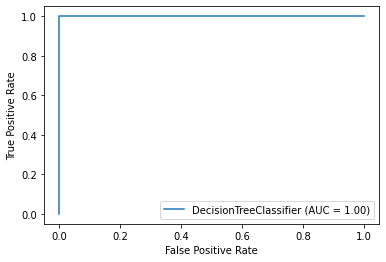

In [ ]:
metrics.plot_roc_curve(clf, xt, y_pred)